# Example: Custom value function and different interaction indices

In [1]:
import xgboost

from folktables import ACSDataSource, ACSIncome

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook", rc={'axes.linewidth': 2, 'grid.linewidth': 1},  font_scale=1.5)

import nshap

### Define the value function

In [2]:
import math

p = 0.1
def v_func(x, S):
    """ The value function from Example 1 in the Faith Shap paper.
    """
    if len(S) <= 1:
        return 0
    return len(S) - p*math.comb(len(S),2)


v_func(None, [1,2,3,4])

3.4

In [3]:
import numpy as np
nshap.shapley_values(np.zeros((1,11)), v_func)

{(0,): 0.49999999999999384, (1,): 0.49999999999999384, (2,): 0.49999999999999384, (3,): 0.49999999999999384, (4,): 0.49999999999999384, (5,): 0.49999999999999384, (6,): 0.49999999999999384, (7,): 0.49999999999999384, (8,): 0.49999999999999384, (9,): 0.49999999999999384, (10,): 0.49999999999999384}

In [4]:
interaction_shapley = nshap.delta_S(np.zeros((1,11)), v_func, 2)
for k,v in interaction_shapley[0].items():
    if np.abs(v) > 1e-8:
        print(k, v)

In [5]:
faith_shap = nshap.faith_shap(np.zeros((1,11)), v_func, 3)
faith_shap

{(0,): 0.7972027972023681, (1,): 0.7972027972023681, (2,): 0.7972027972023681, (3,): 0.7972027972023681, (4,): 0.7972027972023681, (5,): 0.7972027972023681, (6,): 0.7972027972023681, (7,): 0.7972027972023681, (8,): 0.7972027972023681, (9,): 0.7972027972023681, (10,): 0.7972027972023681, (0, 1): 0.003496503496147163, (0, 2): 0.003496503496147163, (0, 3): 0.003496503496147163, (0, 4): 0.003496503496147163, (0, 5): 0.003496503496147163, (0, 6): 0.003496503496147163, (0, 7): 0.003496503496147163, (0, 8): 0.003496503496147163, (0, 9): 0.003496503496147163, (0, 10): 0.003496503496147163, (1, 2): 0.003496503496147163, (1, 3): 0.003496503496147163, (1, 4): 0.003496503496147163, (1, 5): 0.003496503496147163, (1, 6): 0.003496503496147163, (1, 7): 0.003496503496147163, (1, 8): 0.003496503496147163, (1, 9): 0.003496503496147163, (1, 10): 0.003496503496147163, (2, 3): 0.003496503496147163, (2, 4): 0.003496503496147163, (2, 5): 0.003496503496147163, (2, 6): 0.003496503496147163, (2, 7): 0.0034965034

In [6]:
n_shapley = nshap.n_shapley_values(np.zeros((1,11)), v_func, 3)
n_shapley

{(0,): -1.166666666666666, (1,): -1.166666666666666, (2,): -1.166666666666666, (3,): -1.166666666666666, (4,): -1.166666666666666, (5,): -1.166666666666666, (6,): -1.166666666666666, (7,): -1.166666666666666, (8,): -1.166666666666666, (9,): -1.166666666666666, (10,): -1.166666666666666, (0, 1): 0.9999999999999969, (0, 2): 0.9999999999999969, (0, 3): 0.9999999999999969, (0, 4): 0.9999999999999969, (0, 5): 0.9999999999999969, (0, 6): 0.9999999999999969, (0, 7): 0.9999999999999969, (0, 8): 0.9999999999999969, (0, 9): 0.9999999999999969, (0, 10): 0.9999999999999969, (1, 2): 0.9999999999999969, (1, 3): 0.9999999999999969, (1, 4): 0.9999999999999969, (1, 5): 0.9999999999999969, (1, 6): 0.9999999999999969, (1, 7): 0.9999999999999969, (1, 8): 0.9999999999999969, (1, 9): 0.9999999999999969, (1, 10): 0.9999999999999969, (2, 3): 0.9999999999999969, (2, 4): 0.9999999999999969, (2, 5): 0.9999999999999969, (2, 6): 0.9999999999999969, (2, 7): 0.9999999999999969, (2, 8): 0.9999999999999969, (2, 9): 0.

AttributeError: 'InteractionIndex' object has no attribute 'n'

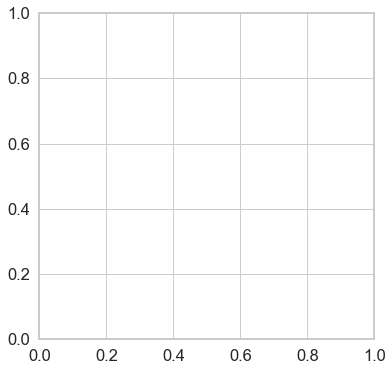

In [7]:
faith_shap.plot()